# Look at cluster with impact

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import FuncFormatter
from brokenaxes import brokenaxes
import xarray as xr 
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime 
import pytz
import csv
import seaborn as sns
from scipy.stats import kde
from scipy.stats import gaussian_kde
import plotly.express as px
from haversine import haversine
from cartopy.geodesic import Geodesic
import shapely.geometry as sgeom
from shapely.geometry import Point, box
import netCDF4
import xskillscore as xs
import geopandas as gpd
from scipy import stats
import rioxarray 
from mpl_toolkits.axes_grid1 import make_axes_locatable
proj = ccrs.PlateCarree()

#Plotting with h3 uber 
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from sklearn.preprocessing import RobustScaler
import h3

#Masking array
from rechunker import rechunk
from rasterio import features
from affine import Affine
from shapely.geometry import Point
from shapely.geometry import Polygon

#External functions 
import fct.preprocess_sinclim as preprocess_sinclim
from fct.paths import *

path_save_fig = PATH_FIGURE

# Open storms with impact

In [3]:
period = "1979-2024WIN"

df_info_storm                       = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_"+period+"_info.csv", encoding='utf-8')
df_info_storm['storm_landing_date'] = pd.to_datetime(df_info_storm['storm_landing_date'])
df_storm                            = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_"+period+".csv", encoding='utf-8')
print(len(df_info_storm))

9881


In [4]:
########## IMPACT DATA 
window              = 'd-3_d+3'
min_claim           = 50
method              = 'wgust'
r_sinclim           = 1300
r_varying           = False
sinclim_version     = "v2.2"
sinclim_date        = "v200126"
sinclim_peril       = "storm" #"storm" # "storm_extended"

sinclim = preprocess_sinclim.open_sinclim_associated(PATH_GENERALI, sinclim_version, sinclim_peril, sinclim_date, window, min_claim, method, "1997-2024", r_sinclim, False)
stormi_impact = sinclim.storm_id.unique()

df_info_storm_impact = df_info_storm.loc[df_info_storm.storm_id.isin(stormi_impact)]
df_storm_impact      = df_storm.loc[df_storm.storm_id.isin(stormi_impact)]
print(f"{df_info_storm_impact.storm_id.nunique()} storms with impact")

#Add storm_landing date and SSI
sinclim = pd.merge(sinclim, df_info_storm_impact, on='storm_id', how='left')

#Load clusters 
windi      = 96
r_cluster  = 700

r_part_sinclim = f"r-varying" if r_varying else f"r{r_sinclim}"
r_part_clust = f"_r{r_cluster}" if r_cluster is not None else ""
fname_cluster = f"tracks_FR_ALL_24h_impact_{sinclim_version}_{sinclim_peril}_{window}-unique-{method}_min{min_claim}_{r_part_sinclim}_{sinclim_date}_clust-mult-2storms-{windi}h{r_part_clust}_{period}"
df_storm_cluster_test                            = pd.read_csv(PATH_TRACKS+fname_cluster+".csv", encoding='utf-8')
df_info_mult_cluster_test                       = pd.read_csv(PATH_TRACKS+fname_cluster+"_info.csv", encoding='utf-8')
df_info_mult_cluster_test['storm_landing_date'] = pd.to_datetime(df_info_mult_cluster_test['storm_landing_date'])
print(f"{df_info_mult_cluster_test.storm_id.nunique()} storms in {df_info_mult_cluster_test.clust_id.nunique()} clusters")

322 storms with impact
161 storms in 72 clusters


In [5]:
## Add information about storm and clustering 
sinclim_clust = sinclim.loc[sinclim.storm_id.isin(df_info_mult_cluster_test.storm_id.unique())]
sinclim_clust = pd.merge(sinclim_clust, df_info_mult_cluster_test[['storm_id', 'clust_id']], on='storm_id', how='left')
# sinclim_clust = pd.merge(sinclim_clust, df_info_mult_cluster_test[['storm_id', 'clust_id', 'NDR_6h_max', 'NDR_24h_max']], on='storm_id', how='left')

## Group per storm 
sinclim_storm_grp = sinclim_clust.groupby(['storm_id', 'clust_id']).agg(
    num_chg_brut =('num_chg_brut_cst', 'sum'), 
    nb_claims    =('num_chg_brut_cst', 'count'),
    storm_landing_date = ('storm_landing_date', 'first'),
#     NDR_6h_max   =('NDR_6h_max', 'first'), 
#     NDR_24h_max  =('NDR_24h_max', 'first'), 
#     SSI_FRA_max = ('SSI_FRA', 'first'), 
#     SSI_EUROPE_max = ('SSI_EUROPE', 'first')
).reset_index()

sinclim_clust_grp = sinclim_clust.groupby('clust_id').agg(
    year = ('year', 'first'),
    num_chg_brut =('num_chg_brut_cst', 'sum'), nb_claims=('num_chg_brut_cst', 'count')).reset_index()

In [6]:
# Add latitude at landing 
def latitude_landing(row) : 
    index = row.storm_id.rindex('_') + 1
    return float(row.storm_id[index:])

sinclim_storm_grp['latitude_landing'] = sinclim_storm_grp.apply(latitude_landing, axis=1)

# Attribution of loss to high-impact cluster events 

In [7]:
sinclim_year = sinclim.groupby('year').agg(num_chg_brut=('num_chg_brut_cst', 'sum'), 
                                           nb_storms=('storm_id', "nunique") 
                                          )
sinclim_clust_step = sinclim.loc[sinclim.storm_id.isin(df_info_mult_cluster_test.storm_id.unique())]
sinclim_clust_year = sinclim_clust_step.groupby(["year"]).agg(num_chg_brut=('num_chg_brut_cst', 'sum'), 
                                                              nb_storms = ("storm_id", "nunique"))

#Print information 
print(sinclim_clust_year.num_chg_brut.sum()/sinclim_year.num_chg_brut.sum())

0.8628057991196916


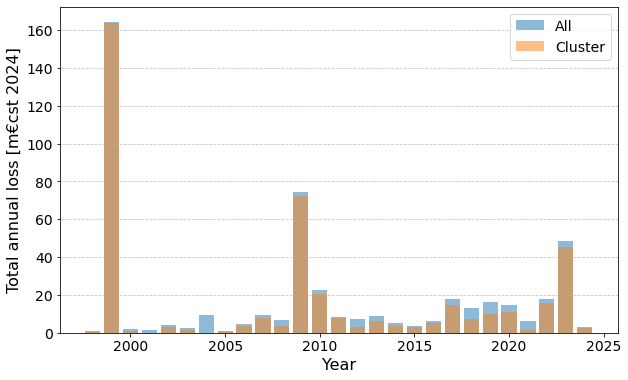

In [8]:
# Plot the annual sum
fig, ax = plt.subplots(1, 1, figsize=(10, 6))                     
#Annual sum
bars_indiv = ax.bar(sinclim_year.index, sinclim_year.num_chg_brut/1e6, label='All', alpha=0.5)
bars_cluster = ax.bar(sinclim_clust_year.index, sinclim_clust_year.num_chg_brut/1e6, label='Cluster', alpha=0.5)
ax.set_ylabel('Total annual loss [m€cst 2024]', fontsize=16) 
ax.legend(fontsize=14)
ax.set_xlabel('Year', fontsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()
# fig.savefig(path_save_fig+"yearly_loss.png", transparent=True, bbox_inches='tight')

In [9]:
sinclim_clust_year.rename(columns={'num_chg_brut': 'num_chg_brut_clust', "nb_storms" : "nb_storms_clust"}, inplace=True)
sinclim_all_year = pd.merge(sinclim_year, sinclim_clust_year, on='year', how='left')
sinclim_all_year.fillna(0, inplace=True)

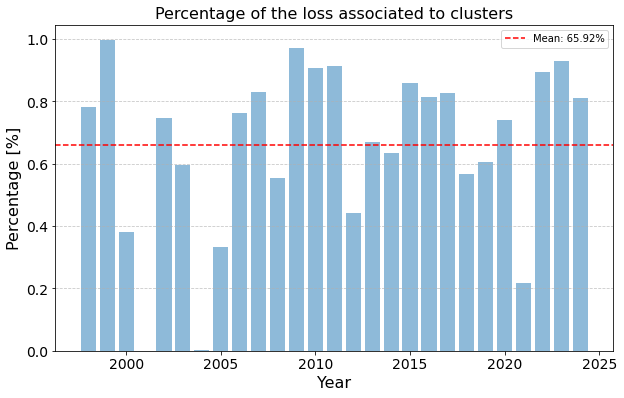

In [10]:
# Plot the annual sum
fig, ax = plt.subplots(1, 1, figsize=(10, 6))                     
#Annual sum
bars_cluster = ax.bar(sinclim_all_year.index, sinclim_all_year.num_chg_brut_clust/sinclim_all_year.num_chg_brut, alpha=0.5)
mean_percentage = np.mean(sinclim_all_year.num_chg_brut_clust/sinclim_all_year.num_chg_brut)
ax.axhline(mean_percentage, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_percentage:.2%}')
ax.set_ylabel('Percentage [%]', fontsize=16) 
ax.legend(fontsize=14)
ax.set_xlabel('Year', fontsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title("Percentage of the loss associated to clusters", fontsize=16)
ax.legend()
plt.show()
# fig.savefig(path_save_fig+"yearly_loss_percentage_cluster.png", transparent=True, bbox_inches='tight')

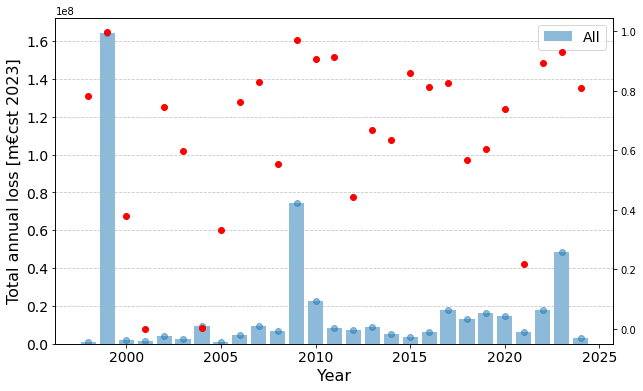

In [11]:
# Plot the annual sum
fig, ax = plt.subplots(1, 1, figsize=(10, 6))                     
#Annual sum
bars_indiv = ax.bar(sinclim_year.index, sinclim_year.num_chg_brut, label='All', alpha=0.5)
ax.scatter(sinclim_year.index, sinclim_year.num_chg_brut, color = bars_indiv[0].get_facecolor())
#bars_cluster = ax.bar(sinclim_clust_year.index, sinclim_clust_year.num_chg_brut, label='Cluster', alpha=0.5)
#ax.scatter(sinclim_clust_year.index, sinclim_clust_year.num_chg_brut, color = bars_cluster[0].get_facecolor())
ax2 = ax.twinx()
ax2.scatter(sinclim_all_year.index, sinclim_all_year.num_chg_brut_clust/sinclim_all_year.num_chg_brut, color="Red")

ax.set_ylabel('Total annual loss [m€cst 2023]', fontsize=16) 
ax.legend(fontsize=14)
ax.set_xlabel('Year', fontsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()
# fig.savefig(path_save_fig+"yearly_loss.png", transparent=True, bbox_inches='tight')

# Shared of the loss - Inside a cluster

In [8]:
def ratio_clust_loss(row):
    try:
#         print(row.clust_id)
#         print(row.num_chg_brut)
#         print(sinclim_clust_grp.loc[sinclim_clust_grp.clust_id == row.clust_id].num_chg_brut.sum())
        return float(row.num_chg_brut / sinclim_clust_grp.loc[sinclim_clust_grp.clust_id == row.clust_id].num_chg_brut.sum())
    except (KeyError, ValueError, AttributeError):
        return np.nan
    
sinclim_storm_grp['ratio_clust_loss'] = sinclim_storm_grp.apply(ratio_clust_loss, axis=1)

In [9]:
def ratio_clust_claims(row):
    try:
#         print(row.clust_id)
#         print(row.num_chg_brut)
#         print(sinclim_clust_grp.loc[sinclim_clust_grp.clust_id == row.clust_id].num_chg_brut.sum())
        return float(row.nb_claims / sinclim_clust_grp.loc[sinclim_clust_grp.clust_id == row.clust_id].nb_claims.sum())
    except (KeyError, ValueError, AttributeError):
        return np.nan
    
sinclim_storm_grp['ratio_clust_claims'] = sinclim_storm_grp.apply(ratio_clust_claims, axis=1)

In [10]:
sinclim_storm_grp = sinclim_storm_grp.dropna(subset=['ratio_clust_loss'])

In [11]:
# Compare several storm clustering metrics 
## Loss rank
sinclim_storm_grp_sort               = sinclim_storm_grp.sort_values(by=["clust_id", "ratio_clust_loss"], ascending=[True, False])
sinclim_storm_grp_sort["loss_rank"] = sinclim_storm_grp_sort.groupby("clust_id").cumcount() + 1

## Occurence rank
sinclim_storm_grp_sort                   = sinclim_storm_grp_sort.sort_values(by=["clust_id", "storm_landing_date"], ascending=[True, True])
sinclim_storm_grp_sort["occurence_rank"] = sinclim_storm_grp_sort.groupby("clust_id").cumcount() + 1

## Damage rank 
sinclim_storm_grp_sort                = sinclim_storm_grp_sort.sort_values(by=["clust_id", "nb_claims"], ascending=[True, False])
sinclim_storm_grp_sort["claim_rank"] = sinclim_storm_grp_sort.groupby("clust_id").cumcount() + 1

# ## SSI rank
# sinclim_storm_grp_sort                = sinclim_storm_grp_sort.sort_values(by=["clust_id", "SSI_FRA_max"], ascending=[True, False])
# sinclim_storm_grp_sort["SSI_rank"]    = sinclim_storm_grp_sort.groupby("clust_id").cumcount() + 1

# ## NDR rank
# sinclim_storm_grp_sort                = sinclim_storm_grp_sort.sort_values(by=["clust_id", "NDR_24h_max"], ascending=[True, False])
# sinclim_storm_grp_sort["NDR24h_rank"] = sinclim_storm_grp_sort.groupby("clust_id").cumcount() + 1

## Latitudinal rank 
sinclim_storm_grp_sort                = sinclim_storm_grp_sort.sort_values(by=["clust_id", "latitude_landing"], ascending=[True, False])
sinclim_storm_grp_sort["latitude_rank"] = sinclim_storm_grp_sort.groupby("clust_id").cumcount() + 1

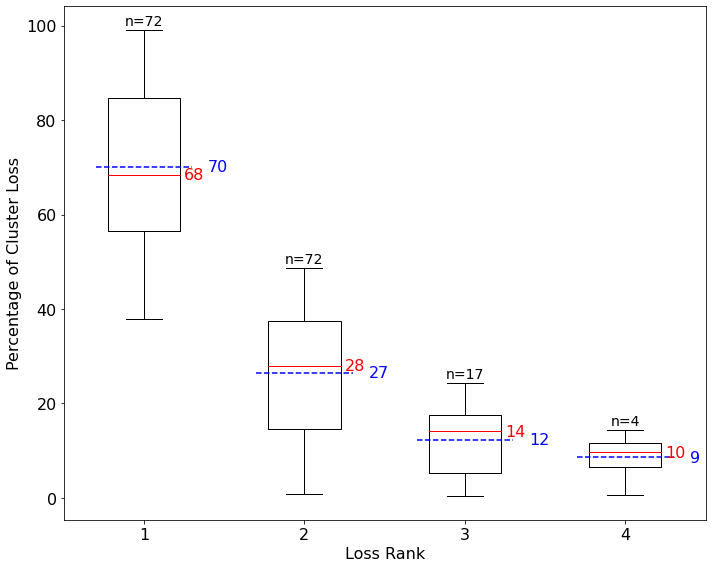

In [12]:
# Plotting the box plot
fig, ax = plt.subplots(figsize=(10, 8))

# Extract data for the boxplot
x = sinclim_storm_grp_sort["loss_rank"]
y = 100*sinclim_storm_grp_sort["ratio_clust_loss"]
unique_ranks = sorted(x.unique())

# Create the box plot
ax.boxplot(
    [y[x == rank] for rank in unique_ranks],  # Group y by unique values of x
    labels=unique_ranks,  # Use sorted unique values of x as labels
#     patch_artist=True,  # Colored boxes
#     boxprops=dict(facecolor='lightblue', color='blue'),  # Box properties
    medianprops=dict(color='red'),  # Median line color
#     whiskerprops=dict(color='blue'),  # Whiskers color
#     capprops=dict(color='blue')  # Caps color
)

# Compute mean values for each loss_rank
mean_values = {rank: y[x == rank].mean() for rank in unique_ranks}
for i, rank in enumerate(unique_ranks, start=1): 
    mean_val = mean_values[rank]
    ax.hlines(mean_val, i - 0.3, i + 0.3, color="blue", linestyle="--", linewidth=1.5)
    ax.text(i + 0.4, mean_val, f"{mean_val:.0f}", verticalalignment="center", fontsize=16, color="blue")
    
# Plot the value of the median
median_values = {rank: y[x == rank].median() for rank in unique_ranks}
for i, rank in enumerate(unique_ranks, start=1): 
    median_val = median_values[rank]
    ax.text(i + 0.25, median_val, f"{median_val:.0f}", verticalalignment="center", fontsize=16, color="red")

# Add the number of cluster in each boxplot 
counts = {rank: (x == rank).sum() for rank in unique_ranks}

for i, rank in enumerate(unique_ranks, start=1):  # Boxplot positions start at 1
    # Text for count — placed above the box
    max_y_val = y[x == rank].max()
    ax.text(i, max_y_val + 1, f"n={counts[rank]}", ha="center", fontsize=14, color="black")

# for axi in ax: 
ax.tick_params(axis='both', which='major', labelsize=16)
    
# Labels and layout
plt.xlabel("Loss Rank", fontsize=16)
plt.ylabel("Percentage of Cluster Loss", fontsize=16)
plt.tight_layout()
plt.show()

# Save figure
# fig.savefig(path_save_fig+f"Ratio_loss_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-{windi}h-r{r_cluster}.png", 
#             transparent=True, bbox_inches='tight', dpi=300)
# fig.savefig(path_save_fig+f"Ratio_loss_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-{windi}h-r{r_cluster}.svg", 
#             format="svg", transparent=True, bbox_inches='tight', dpi=300)
# fig.savefig(path_save_fig+f"Ratio_loss_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-{windi}h-r{r_cluster}.pdf", 
#             format="pdf", transparent=True, bbox_inches='tight', dpi=300)

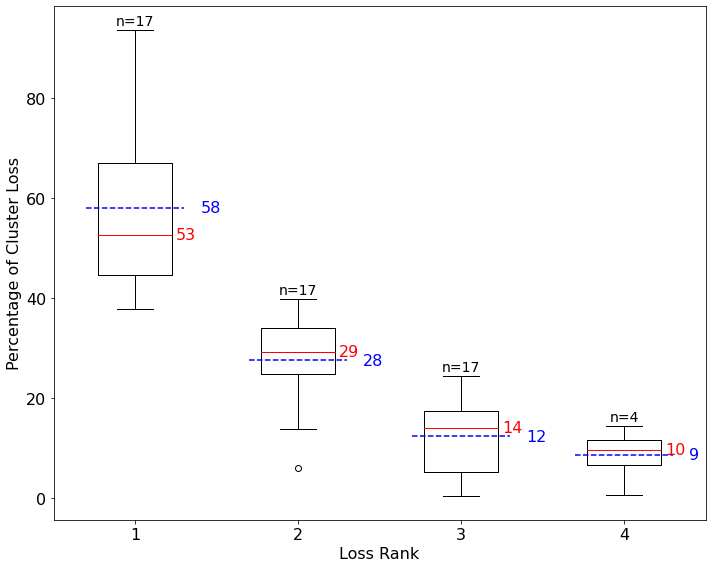

In [13]:
#### Focus over cluster with more than 3 storms with impact
sinclim_storm_grp_sort_filtered = (
    sinclim_storm_grp_sort
    .groupby("clust_id")
    .filter(lambda x: len(x) >= 3)
)

# Plotting the box plot
fig, ax = plt.subplots(figsize=(10, 8))

# Extract data for the boxplot
x = sinclim_storm_grp_sort_filtered["loss_rank"]
y = 100*sinclim_storm_grp_sort_filtered["ratio_clust_loss"]
unique_ranks = sorted(x.unique())

# Create the box plot
ax.boxplot(
    [y[x == rank] for rank in unique_ranks],  # Group y by unique values of x
    labels=unique_ranks,  # Use sorted unique values of x as labels
#     patch_artist=True,  # Colored boxes
#     boxprops=dict(facecolor='lightblue', color='blue'),  # Box properties
    medianprops=dict(color='red'),  # Median line color
#     whiskerprops=dict(color='blue'),  # Whiskers color
#     capprops=dict(color='blue')  # Caps color
)

# Compute mean values for each loss_rank
mean_values = {rank: y[x == rank].mean() for rank in unique_ranks}
for i, rank in enumerate(unique_ranks, start=1): 
    mean_val = mean_values[rank]
    ax.hlines(mean_val, i - 0.3, i + 0.3, color="blue", linestyle="--", linewidth=1.5)
    ax.text(i + 0.4, mean_val, f"{mean_val:.0f}", verticalalignment="center", fontsize=16, color="blue")
    
# Plot the value of the median
median_values = {rank: y[x == rank].median() for rank in unique_ranks}
for i, rank in enumerate(unique_ranks, start=1): 
    median_val = median_values[rank]
    ax.text(i + 0.25, median_val, f"{median_val:.0f}", verticalalignment="center", fontsize=16, color="red")

# Add the number of cluster in each boxplot 
counts = {rank: (x == rank).sum() for rank in unique_ranks}

for i, rank in enumerate(unique_ranks, start=1):  # Boxplot positions start at 1
    # Text for count — placed above the box
    max_y_val = y[x == rank].max()
    ax.text(i, max_y_val + 1, f"n={counts[rank]}", ha="center", fontsize=14, color="black")

# for axi in ax: 
ax.tick_params(axis='both', which='major', labelsize=16)
    
# Labels and layout
plt.xlabel("Loss Rank", fontsize=16)
plt.ylabel("Percentage of Cluster Loss", fontsize=16)
plt.tight_layout()
plt.show()

# Save figure
# fig.savefig(path_save_fig+f"Ratio_loss_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-3storms-{windi}h-r{r_cluster}.png", 
#             transparent=True, bbox_inches='tight', dpi=300)
# fig.savefig(path_save_fig+f"Ratio_loss_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-3storms-{windi}h-r{r_cluster}.svg", 
#             format="svg", transparent=True, bbox_inches='tight', dpi=300)
# fig.savefig(path_save_fig+f"Ratio_loss_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-3storms-{windi}h-r{r_cluster}.pdf", 
#             format="pdf", transparent=True, bbox_inches='tight', dpi=300)

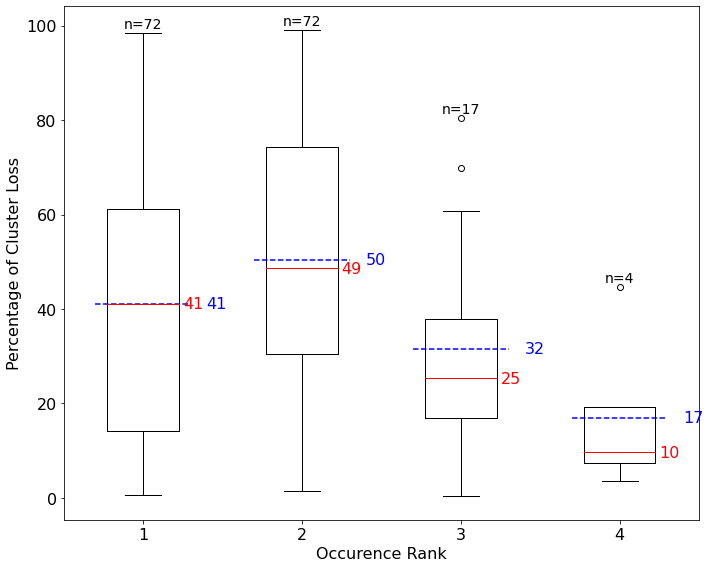

In [14]:
# Plotting the box plot
fig, ax = plt.subplots(figsize=(10, 8))

# Extract data for the boxplot
x = sinclim_storm_grp_sort["occurence_rank"]
y = 100*sinclim_storm_grp_sort["ratio_clust_loss"]
unique_ranks = sorted(x.unique())

# Create the box plot
ax.boxplot(
    [y[x == rank] for rank in unique_ranks],  # Group y by unique values of x
    labels=unique_ranks,  # Use sorted unique values of x as labels
#     patch_artist=True,  # Colored boxes
#     boxprops=dict(facecolor='lightblue', color='blue'),  # Box properties
    medianprops=dict(color='red'),  # Median line color
#     whiskerprops=dict(color='blue'),  # Whiskers color
#     capprops=dict(color='blue')  # Caps color
)

# Compute mean values for each loss_rank
mean_values = {rank: y[x == rank].mean() for rank in unique_ranks}
for i, rank in enumerate(unique_ranks, start=1): 
    mean_val = mean_values[rank]
    ax.hlines(mean_val, i - 0.3, i + 0.3, color="blue", linestyle="--", linewidth=1.5)
    ax.text(i + 0.4, mean_val, f"{mean_val:.0f}", verticalalignment="center", fontsize=16, color="blue")
    
# Plot the value of the median
median_values = {rank: y[x == rank].median() for rank in unique_ranks}
for i, rank in enumerate(unique_ranks, start=1): 
    median_val = median_values[rank]
    ax.text(i + 0.25, median_val, f"{median_val:.0f}", verticalalignment="center", fontsize=16, color="red")

# Add the number of cluster in each boxplot 
counts = {rank: (x == rank).sum() for rank in unique_ranks}

for i, rank in enumerate(unique_ranks, start=1):  # Boxplot positions start at 1
    # Text for count — placed above the box
    max_y_val = y[x == rank].max()
    ax.text(i, max_y_val + 1, f"n={counts[rank]}", ha="center", fontsize=14, color="black")

# for axi in ax: 
ax.tick_params(axis='both', which='major', labelsize=16)
    
# Labels and layout
plt.xlabel("Occurence Rank", fontsize=16)
plt.ylabel("Percentage of Cluster Loss", fontsize=16)
plt.tight_layout()
plt.show()

# Save figure 
# fig.savefig(path_save_fig+f"Ratio_loss_occurence_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-{windi}h-r{r_cluster}.png", 
#             transparent=True, bbox_inches='tight', dpi=300)
# fig.savefig(path_save_fig+f"Ratio_loss_occurence_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-{windi}h-r{r_cluster}.svg", 
#             format="svg", transparent=True, bbox_inches='tight', dpi=300)
# fig.savefig(path_save_fig+f"Ratio_loss_occurence_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-{windi}h-r{r_cluster}.pdf", 
#             format="pdf", transparent=True, bbox_inches='tight', dpi=300)

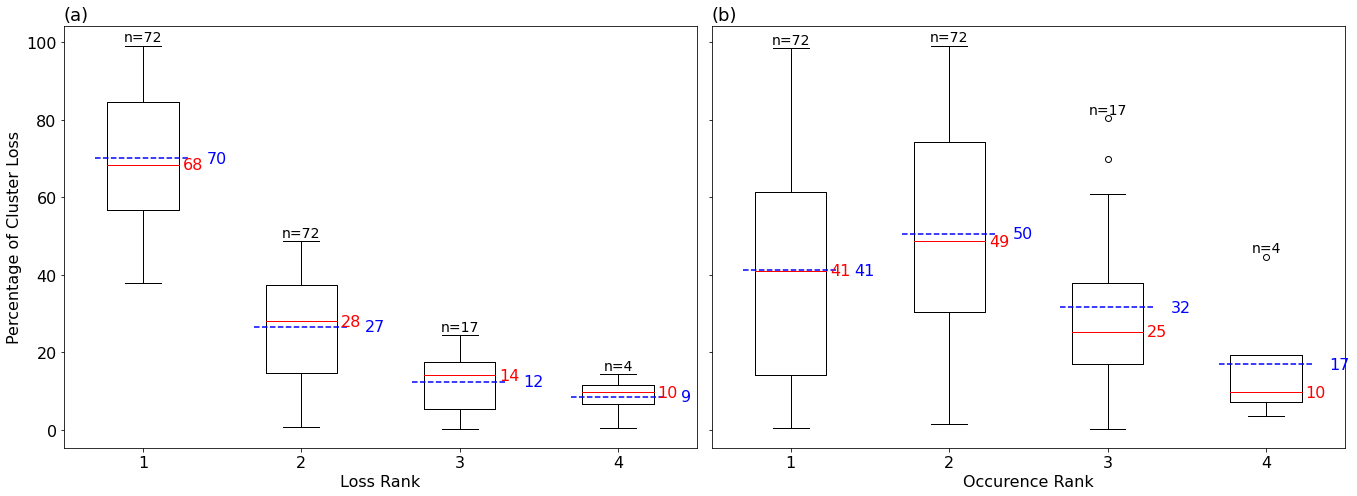

In [16]:
# Plotting the box plot
fig, ax = plt.subplots(1, 2, figsize=(19, 7), sharey=True)

############################################ FIGURE (A) #############################################################

# Extract data for the boxplot
x = sinclim_storm_grp_sort["loss_rank"]
y = 100*sinclim_storm_grp_sort["ratio_clust_loss"]
unique_ranks = sorted(x.unique())

# Create the box plot
ax[0].boxplot(
    [y[x == rank] for rank in unique_ranks],  
    labels=unique_ranks, 
    medianprops=dict(color='red'), 
)

# Compute mean values for each loss_rank
mean_values = {rank: y[x == rank].mean() for rank in unique_ranks}
for i, rank in enumerate(unique_ranks, start=1): 
    mean_val = mean_values[rank]
    ax[0].hlines(mean_val, i - 0.3, i + 0.3, color="blue", linestyle="--", linewidth=1.5)
    ax[0].text(i + 0.4, mean_val, f"{mean_val:.0f}", verticalalignment="center", fontsize=16, color="blue")
    
# Plot the value of the median
median_values = {rank: y[x == rank].median() for rank in unique_ranks}
for i, rank in enumerate(unique_ranks, start=1): 
    median_val = median_values[rank]
    ax[0].text(i + 0.25, median_val, f"{median_val:.0f}", verticalalignment="center", fontsize=16, color="red")

# Add the number of cluster in each boxplot 
counts = {rank: (x == rank).sum() for rank in unique_ranks}

for i, rank in enumerate(unique_ranks, start=1):  # Boxplot positions start at 1
    # Text for count — placed above the box
    max_y_val = y[x == rank].max()
    ax[0].text(i, max_y_val + 1, f"n={counts[rank]}", ha="center", fontsize=14, color="black")

# for axi in ax: 
ax[0].tick_params(axis='both', which='major', labelsize=16)
    
# Labels and layout
ax[0].set_xlabel("Loss Rank", fontsize=16)
ax[0].set_ylabel("Percentage of Cluster Loss", fontsize=16)
ax[0].set_title("(a)", loc='left', fontsize=18)

############################################ FIGURE (B) #############################################################
# Extract data for the boxplot
x = sinclim_storm_grp_sort["occurence_rank"]
y = 100*sinclim_storm_grp_sort["ratio_clust_loss"]
unique_ranks = sorted(x.unique())

# Create the box plot
ax[1].boxplot(
    [y[x == rank] for rank in unique_ranks],  # Group y by unique values of x
    labels=unique_ranks,  # Use sorted unique values of x as labels
#     patch_artist=True,  # Colored boxes
#     boxprops=dict(facecolor='lightblue', color='blue'),  # Box properties
    medianprops=dict(color='red'),  # Median line color
#     whiskerprops=dict(color='blue'),  # Whiskers color
#     capprops=dict(color='blue')  # Caps color
)

# Compute mean values for each loss_rank
mean_values = {rank: y[x == rank].mean() for rank in unique_ranks}
for i, rank in enumerate(unique_ranks, start=1): 
    mean_val = mean_values[rank]
    ax[1].hlines(mean_val, i - 0.3, i + 0.3, color="blue", linestyle="--", linewidth=1.5)
    ax[1].text(i + 0.4, mean_val, f"{mean_val:.0f}", verticalalignment="center", fontsize=16, color="blue")
    
# Plot the value of the median
median_values = {rank: y[x == rank].median() for rank in unique_ranks}
for i, rank in enumerate(unique_ranks, start=1): 
    median_val = median_values[rank]
    ax[1].text(i + 0.25, median_val, f"{median_val:.0f}", verticalalignment="center", fontsize=16, color="red")

# Add the number of cluster in each boxplot 
counts = {rank: (x == rank).sum() for rank in unique_ranks}

for i, rank in enumerate(unique_ranks, start=1):  # Boxplot positions start at 1
    # Text for count — placed above the box
    max_y_val = y[x == rank].max()
    ax[1].text(i, max_y_val + 1, f"n={counts[rank]}", ha="center", fontsize=14, color="black")

# for axi in ax: 
ax[1].tick_params(axis='both', which='major', labelsize=16)
    
# Labels and layout
ax[1].set_xlabel("Occurence Rank", fontsize=16)
ax[1].set_title("(b)", loc='left', fontsize=18)

plt.tight_layout()
plt.show()

# Save figure
fig.savefig(path_save_fig+f"Ratio_loss_and_occurence_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-{windi}h-r{r_cluster}.png", 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+f"Ratio_loss_and_occurence_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-{windi}h-r{r_cluster}.svg", 
            format="svg", transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+f"Ratio_loss_and_occurence_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-{windi}h-r{r_cluster}.pdf", 
            format="pdf", transparent=True, bbox_inches='tight', dpi=300)

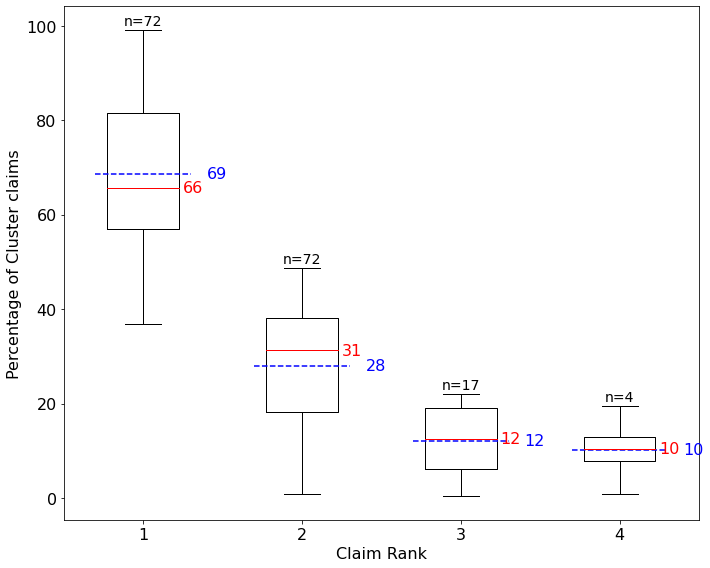

In [21]:
# Plotting the box plot
fig, ax = plt.subplots(figsize=(10, 8))

# Extract data for the boxplot
x = sinclim_storm_grp_sort["claim_rank"]
y = 100*sinclim_storm_grp_sort["ratio_clust_claims"]
unique_ranks = sorted(x.unique())

# Create the box plot
ax.boxplot(
    [y[x == rank] for rank in unique_ranks],  # Group y by unique values of x
    labels=unique_ranks,  # Use sorted unique values of x as labels
#     patch_artist=True,  # Colored boxes
#     boxprops=dict(facecolor='lightblue', color='blue'),  # Box properties
    medianprops=dict(color='red'),  # Median line color
#     whiskerprops=dict(color='blue'),  # Whiskers color
#     capprops=dict(color='blue')  # Caps color
)

# Compute mean values for each loss_rank
mean_values = {rank: y[x == rank].mean() for rank in unique_ranks}
for i, rank in enumerate(unique_ranks, start=1): 
    mean_val = mean_values[rank]
    ax.hlines(mean_val, i - 0.3, i + 0.3, color="blue", linestyle="--", linewidth=1.5)
    ax.text(i + 0.4, mean_val, f"{mean_val:.0f}", verticalalignment="center", fontsize=16, color="blue")
    
# Plot the value of the median
median_values = {rank: y[x == rank].median() for rank in unique_ranks}
for i, rank in enumerate(unique_ranks, start=1): 
    median_val = median_values[rank]
    ax.text(i + 0.25, median_val, f"{median_val:.0f}", verticalalignment="center", fontsize=16, color="red")

# Add the number of cluster in each boxplot 
counts = {rank: (x == rank).sum() for rank in unique_ranks}

for i, rank in enumerate(unique_ranks, start=1):  # Boxplot positions start at 1
    # Text for count — placed above the box
    max_y_val = y[x == rank].max()
    ax.text(i, max_y_val + 1, f"n={counts[rank]}", ha="center", fontsize=14, color="black")

# for axi in ax: 
ax.tick_params(axis='both', which='major', labelsize=16)
    
# Labels and layout
plt.xlabel("Claim Rank", fontsize=16)
plt.ylabel("Percentage of Cluster claims", fontsize=16)
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(path_save_fig+f"Ratio_claims_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-{windi}h-r{r_cluster}.png", 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+f"Ratio_claims_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-{windi}h-r{r_cluster}.svg", 
            format="svg", transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+f"Ratio_claims_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-{windi}h-r{r_cluster}.pdf", 
            format="pdf", transparent=True, bbox_inches='tight', dpi=300)

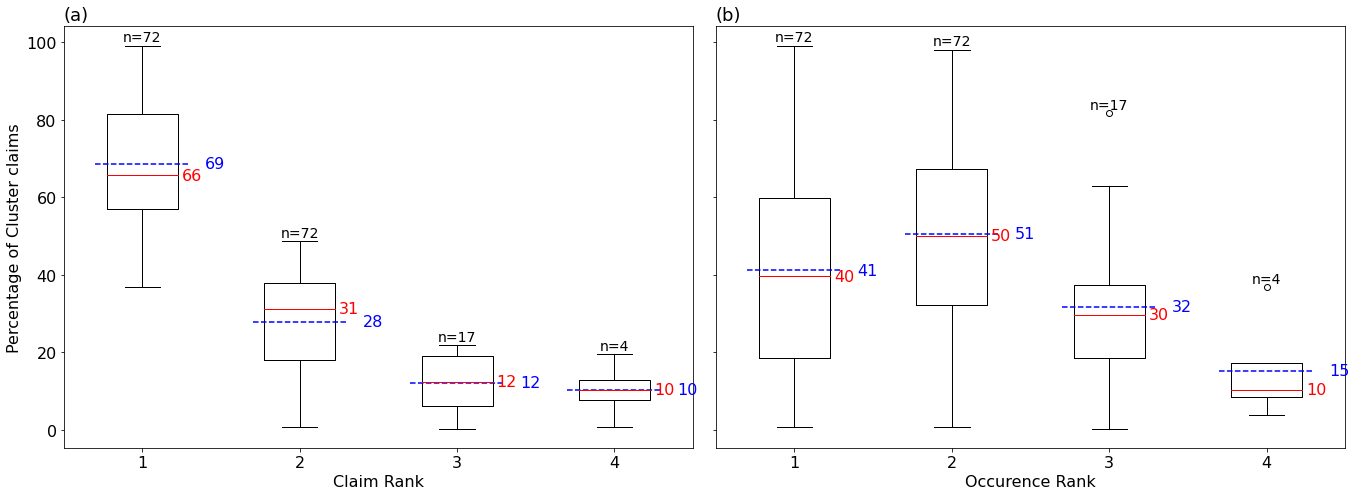

In [17]:
# Plotting the box plot
fig, ax = plt.subplots(1, 2, figsize=(19, 7), sharey=True)

############################################ FIGURE (A) #############################################################

# Extract data for the boxplot
x = sinclim_storm_grp_sort["claim_rank"]
y = 100*sinclim_storm_grp_sort["ratio_clust_claims"]
unique_ranks = sorted(x.unique())

# Create the box plot
ax[0].boxplot(
    [y[x == rank] for rank in unique_ranks],  
    labels=unique_ranks, 
    medianprops=dict(color='red'), 
)

# Compute mean values for each loss_rank
mean_values = {rank: y[x == rank].mean() for rank in unique_ranks}
for i, rank in enumerate(unique_ranks, start=1): 
    mean_val = mean_values[rank]
    ax[0].hlines(mean_val, i - 0.3, i + 0.3, color="blue", linestyle="--", linewidth=1.5)
    ax[0].text(i + 0.4, mean_val, f"{mean_val:.0f}", verticalalignment="center", fontsize=16, color="blue")
    
# Plot the value of the median
median_values = {rank: y[x == rank].median() for rank in unique_ranks}
for i, rank in enumerate(unique_ranks, start=1): 
    median_val = median_values[rank]
    ax[0].text(i + 0.25, median_val, f"{median_val:.0f}", verticalalignment="center", fontsize=16, color="red")

# Add the number of cluster in each boxplot 
counts = {rank: (x == rank).sum() for rank in unique_ranks}

for i, rank in enumerate(unique_ranks, start=1):  # Boxplot positions start at 1
    # Text for count — placed above the box
    max_y_val = y[x == rank].max()
    ax[0].text(i, max_y_val + 1, f"n={counts[rank]}", ha="center", fontsize=14, color="black")

# for axi in ax: 
ax[0].tick_params(axis='both', which='major', labelsize=16)
    
# Labels and layout
ax[0].set_xlabel("Claim Rank", fontsize=16)
ax[0].set_ylabel("Percentage of Cluster claims", fontsize=16)
ax[0].set_title("(a)", loc='left', fontsize=18)

############################################ FIGURE (B) #############################################################
# Extract data for the boxplot
x = sinclim_storm_grp_sort["occurence_rank"]
y = 100*sinclim_storm_grp_sort["ratio_clust_claims"]
unique_ranks = sorted(x.unique())

# Create the box plot
ax[1].boxplot(
    [y[x == rank] for rank in unique_ranks],  # Group y by unique values of x
    labels=unique_ranks,  # Use sorted unique values of x as labels
#     patch_artist=True,  # Colored boxes
#     boxprops=dict(facecolor='lightblue', color='blue'),  # Box properties
    medianprops=dict(color='red'),  # Median line color
#     whiskerprops=dict(color='blue'),  # Whiskers color
#     capprops=dict(color='blue')  # Caps color
)

# Compute mean values for each loss_rank
mean_values = {rank: y[x == rank].mean() for rank in unique_ranks}
for i, rank in enumerate(unique_ranks, start=1): 
    mean_val = mean_values[rank]
    ax[1].hlines(mean_val, i - 0.3, i + 0.3, color="blue", linestyle="--", linewidth=1.5)
    ax[1].text(i + 0.4, mean_val, f"{mean_val:.0f}", verticalalignment="center", fontsize=16, color="blue")
    
# Plot the value of the median
median_values = {rank: y[x == rank].median() for rank in unique_ranks}
for i, rank in enumerate(unique_ranks, start=1): 
    median_val = median_values[rank]
    ax[1].text(i + 0.25, median_val, f"{median_val:.0f}", verticalalignment="center", fontsize=16, color="red")

# Add the number of cluster in each boxplot 
counts = {rank: (x == rank).sum() for rank in unique_ranks}

for i, rank in enumerate(unique_ranks, start=1):  # Boxplot positions start at 1
    # Text for count — placed above the box
    max_y_val = y[x == rank].max()
    ax[1].text(i, max_y_val + 1, f"n={counts[rank]}", ha="center", fontsize=14, color="black")

# for axi in ax: 
ax[1].tick_params(axis='both', which='major', labelsize=16)
    
# Labels and layout
ax[1].set_xlabel("Occurence Rank", fontsize=16)
ax[1].set_title("(b)", loc='left', fontsize=18)

plt.tight_layout()
plt.show()

# Save figure
fig.savefig(path_save_fig+f"Ratio_claims_and_occurence_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-{windi}h-r{r_cluster}.png", 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+f"Ratio_claims_and_occurence_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-{windi}h-r{r_cluster}.svg", 
            format="svg", transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+f"Ratio_claims_and_occurence_impactful-{method}-{window}-min{min_claim}_r{r_sinclim}_clusters-{windi}h-r{r_cluster}.pdf", 
            format="pdf", transparent=True, bbox_inches='tight', dpi=300)

KeyError: 'SSI_rank'

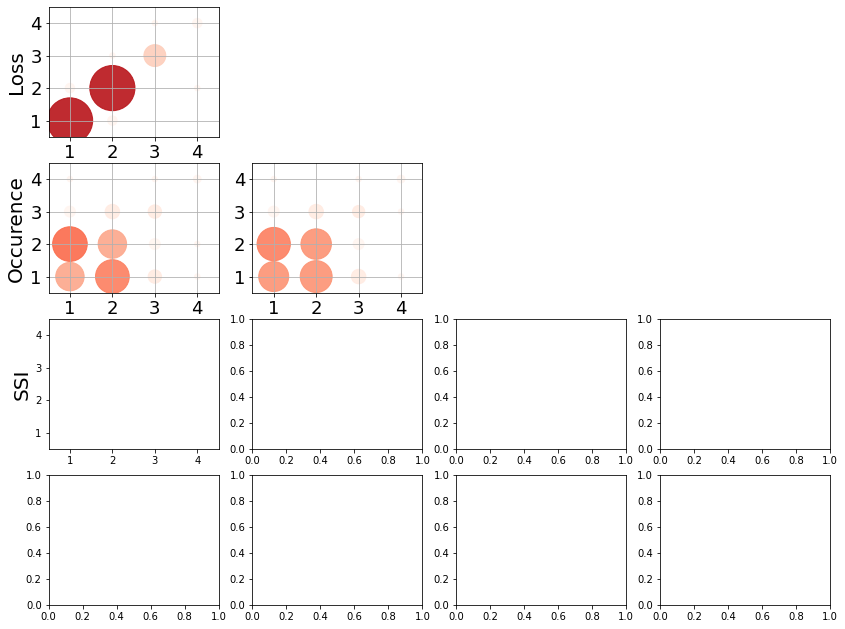

In [23]:
columns = ['claim_rank', 'loss_rank', 'occurence_rank', 'SSI_rank', 'NDR24h_rank']
label_names = {'claim_rank' : "Claims", "loss_rank" : "Loss", "occurence_rank" : "Occurence", "SSI_rank" : "SSI", "NDR24h_rank" : "NDR24h"}
n_variables = len(columns)

# Define levels and colormap
levels = np.arange(0, 85, 5)
cmap = plt.cm.Reds
norm = BoundaryNorm(levels, ncolors=cmap.N, extend='max')

# Create subplots
fig, axes = plt.subplots(n_variables-1, n_variables-1, figsize=(14, 11))

# Plot each combination
for i, y_col in enumerate(columns[1:]):
    for j, x_col in enumerate(columns[:-1]):
        ax = axes[i, j]

        # Skip plots where j > i (upper triangle)
        if j > i:
            ax.axis('off')  # Turn off these axes
            continue

        # Customize the axes
        ax.set_xlim(0.5, 4.5)
        ax.set_ylim(0.5, 4.5)

        # Add y-labels to the first column
        if j == 0:
            ax.set_ylabel(label_names[y_col], fontsize=20)

        # Add x-labels to the last row
        if i == n_variables - 2:
            ax.set_xlabel(label_names[x_col], fontsize=20)

        # Count the frequency of each (x, y) pair
        counts = sinclim_storm_grp_sort.groupby([x_col, y_col]).size().reset_index(name='count')

        # Scatter plot
        scatter = ax.scatter(
            counts[x_col], counts[y_col],
            s=counts['count'] * 30,  # Adjust size scaling as needed
#             s=500,
            c=counts['count'], cmap=cmap, norm=norm, alpha=0.9
        )
        #ax.scatter(counts[x_col], counts[y_col], s=20, color='black')  # Add black outlines
        ax.tick_params(axis='both', which='both', labelsize=18)
        ax.xaxis.set_ticks(np.arange(1, 5))
        ax.yaxis.set_ticks(np.arange(1, 5))
        ax.grid(True)

# Add a single color bar on the left
cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', extend='both', shrink=0.95, pad=0.1, location='left')
cbar.ax.tick_params(labelsize=18)
cbar.set_label('# storms', fontsize=20)

# Title 
plt.suptitle("Ranking Correlation on High-Impact clusters", x = (1-0.28)/2+0.28,fontsize=22)

# Adjust layout
plt.tight_layout(rect=[0.28, 0, 1, 0.98])
plt.show()

#SAVE FIG
# fig.savefig(path_save_fig+'ranking_correlation_impactful-'+method+'-'+window+'-min'+str(min_claim)+'_clusters-96h-r700.png', 
#             transparent=True, bbox_inches='tight', dpi=400)
# fig.savefig(path_save_fig+'ranking_correlation_impactful-'+method+'-'+window+'-min'+str(min_claim)+'_clusters-96h-r700.svg', 
#             format="svg", bbox_inches="tight", dpi=400, transparent=True)

<ipython-input-22-e0c5ffcff6c1>:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.28, 0, 1, 0.98])


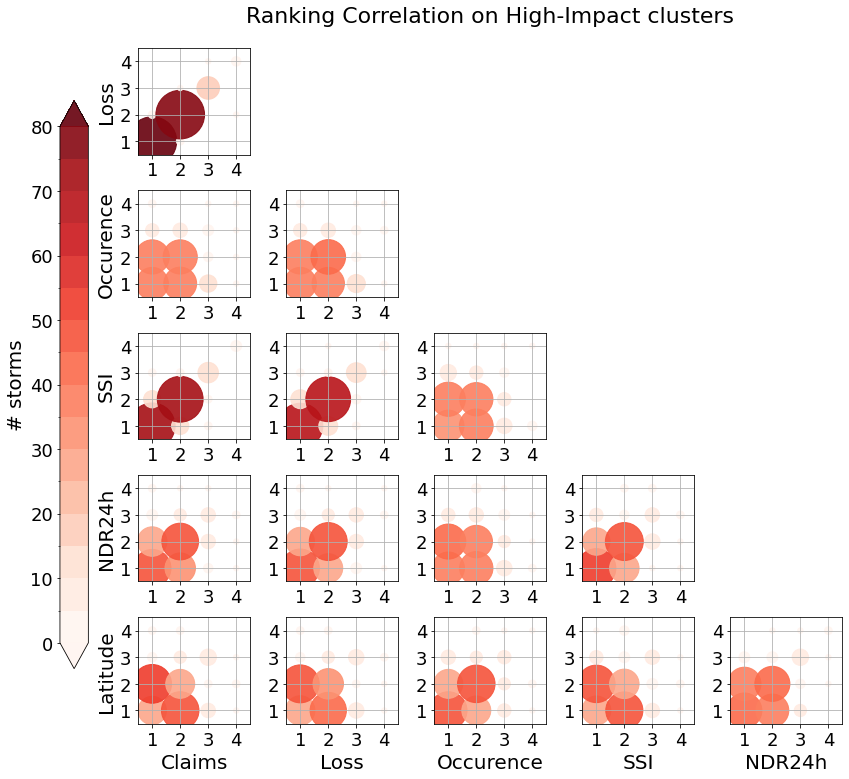

In [22]:
columns = ['claim_rank', 'loss_rank', 'occurence_rank', 'SSI_rank', 'NDR24h_rank', "latitude_rank"]
label_names = {'claim_rank' : "Claims", "loss_rank" : "Loss", 
               "occurence_rank" : "Occurence", "SSI_rank" : "SSI", 
               "NDR24h_rank" : "NDR24h", "latitude_rank" : "Latitude"}
n_variables = len(columns)

# Define levels and colormap
levels = np.arange(0, 85, 5)
cmap = plt.cm.Reds
norm = BoundaryNorm(levels, ncolors=cmap.N, extend='max')

# Create subplots
fig, axes = plt.subplots(n_variables-1, n_variables-1, figsize=(14, 11))

# Plot each combination
for i, y_col in enumerate(columns[1:]):
    for j, x_col in enumerate(columns[:-1]):
        ax = axes[i, j]

        # Skip plots where j > i (upper triangle)
        if j > i:
            ax.axis('off')  # Turn off these axes
            continue

        # Customize the axes
        ax.set_xlim(0.5, 4.5)
        ax.set_ylim(0.5, 4.5)

        # Add y-labels to the first column
        if j == 0:
            ax.set_ylabel(label_names[y_col], fontsize=20)

        # Add x-labels to the last row
        if i == n_variables - 2:
            ax.set_xlabel(label_names[x_col], fontsize=20)

        # Count the frequency of each (x, y) pair
        counts = sinclim_storm_grp_sort.groupby([x_col, y_col]).size().reset_index(name='count')

        # Scatter plot
        scatter = ax.scatter(
            counts[x_col], counts[y_col],
            s=counts['count'] * 30,  # Adjust size scaling as needed
#             s=500,
            c=counts['count'], cmap=cmap, norm=norm, alpha=0.9
        )
        #ax.scatter(counts[x_col], counts[y_col], s=20, color='black')  # Add black outlines
        ax.tick_params(axis='both', which='both', labelsize=18)
        ax.xaxis.set_ticks(np.arange(1, 5))
        ax.yaxis.set_ticks(np.arange(1, 5))
        ax.grid(True)

# Add a single color bar on the left
cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', extend='both', shrink=0.95, pad=0.1, location='left')
cbar.ax.tick_params(labelsize=18)
cbar.set_label('# storms', fontsize=20)

# Title 
plt.suptitle("Ranking Correlation on High-Impact clusters", x = (1-0.28)/2+0.28,fontsize=22)

# Adjust layout
plt.tight_layout(rect=[0.28, 0, 1, 0.98])
plt.show()
# fig.savefig(path_save_fig+'ranking_correlation_impactful-'+method+'-'+window+'-min'+str(min_claim)+'_clusters-96h-r700.png', transparent=True, bbox_inches='tight')

<ipython-input-39-6f126dc19bdc>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.28, 0, 1, 0.98])


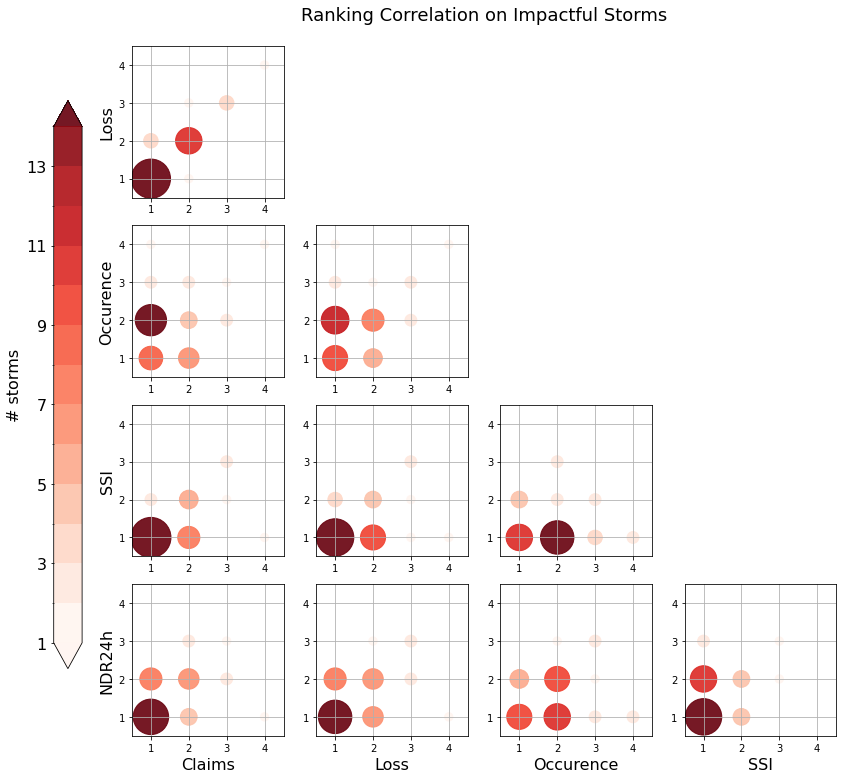

In [39]:
### Filter on storms with a non nul SSI_FRA
sinclim_storm_grp_sort_subset = sinclim_storm_grp_sort.loc[sinclim_storm_grp_sort.SSI_FRA_max != 0]

columns = ['claim_rank', 'loss_rank', 'occurence_rank', 'SSI_rank', 'NDR24h_rank']
label_names = {'claim_rank' : "Claims", "loss_rank" : "Loss", "occurence_rank" : "Occurence", "SSI_rank" : "SSI", "NDR24h_rank" : "NDR24h"}
n_variables = len(columns)

# Define levels and colormap
levels = np.arange(1, 15)
cmap = plt.cm.Reds
norm = BoundaryNorm(levels, ncolors=cmap.N, extend='max')

# Create subplots
fig, axes = plt.subplots(n_variables-1, n_variables-1, figsize=(14, 11))

# Plot each combination
for i, y_col in enumerate(columns[1:]):
    for j, x_col in enumerate(columns[:-1]):
        ax = axes[i, j]

        # Skip plots where j > i (upper triangle)
        if j > i:
            ax.axis('off')  # Turn off these axes
            continue

        # Customize the axes
        ax.set_xlim(0.5, 4.5)
        ax.set_ylim(0.5, 4.5)

        # Add y-labels to the first column
        if j == 0:
            ax.set_ylabel(label_names[y_col], fontsize=16)

        # Add x-labels to the last row
        if i == n_variables - 2:
            ax.set_xlabel(label_names[x_col], fontsize=16)

        # Count the frequency of each (x, y) pair
        counts = sinclim_storm_grp_sort_subset.groupby([x_col, y_col]).size().reset_index(name='count')

        # Scatter plot
        scatter = ax.scatter(
            counts[x_col], counts[y_col],
            s=counts['count'] * 70,  # Adjust size scaling as needed
#             s=500,
            c=counts['count'], cmap=cmap, norm=norm, alpha=0.9
        )
        #ax.scatter(counts[x_col], counts[y_col], s=20, color='black')  # Add black outlines

        ax.grid(True)

# Add a single color bar on the left
cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', extend='both', shrink=0.95, pad=0.1, location='left')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('# storms', fontsize=16)

# Title 
plt.suptitle("Ranking Correlation on Impactful Storms", x = (1-0.28)/2+0.28,fontsize=18)

# Adjust layout
plt.tight_layout(rect=[0.28, 0, 1, 0.98])
plt.show()
# fig.savefig(path_save_fig+'ranking_correlation_impactful-'+method+'-'+window+'-min'+str(min_claim)+'_clusters-96h-r700.png', transparent=True, bbox_inches='tight')